# José Ligorría

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%load_ext tensorboard

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,000 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

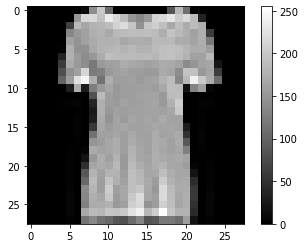

In [5]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

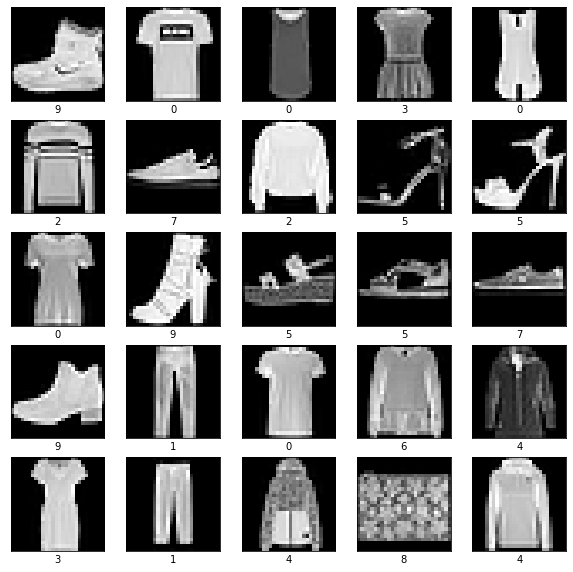

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [8]:
id_labels = range(10)
str_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

dict_labels = dict(zip(id_labels,str_labels))
dict_labels

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [9]:
elegidas_0 = train_labels == 0 
elegidas_1 = train_labels == 1 
elegidas_2 = train_labels == 2
elegidas_3 = train_labels == 3
elegidas_4 = train_labels == 4 
elegidas_5 = train_labels == 5
a = elegidas_0 + elegidas_1 + elegidas_2 + elegidas_3 + elegidas_4 + elegidas_5
(train_images_sub, train_labels_sub) = (train_images[a],train_labels[a])
elegidas_0 = test_labels == 0 
elegidas_1 = test_labels == 1 
elegidas_2 = test_labels == 2
elegidas_3 = test_labels == 3 
elegidas_4 = test_labels == 4 
elegidas_5 = test_labels == 5
a = elegidas_0 + elegidas_1 + elegidas_2 + elegidas_3 + elegidas_4 + elegidas_5
(test_images_sub, test_labels_sub) = (test_images[a], test_labels[a])
n_train_labels_sub = np.max(train_labels_sub) + 1
train_labels_sub_onehot = np.eye(n_train_labels_sub)[train_labels_sub]

In [10]:
len(train_images_sub)

36000

In [11]:
class ModeloRegresionLogistica:
    def __init__(self):
        tf.reset_default_graph()
        self.m = tf.get_variable("pendientes",dtype=tf.float32,shape=[28,28,6],initializer=tf.zeros_initializer())
        self.b = tf.get_variable("intercepto",dtype=tf.float32,shape=[6],initializer=tf.zeros_initializer())
        self.scale = tf.get_variable("scale",dtype=tf.bool,initializer=False)
        self.los_sd = tf.get_variable("sd",dtype=tf.float32,shape=[28,28],initializer=tf.ones_initializer())
        self.los_mean = tf.get_variable("mean",dtype=tf.float32,shape=[28,28],initializer=tf.zeros_initializer())

    def __call__(self,x):
        return tf.nn.sigmoid(tf.add(tf.tensordot((x-self.los_mean)/self.los_sd, self.m,axes = [[2,1], [0,1]]), self.b)) 

    def actualizar(self,x,y,learning_rate):
        prediccion = self(x)
        cost = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits = prediccion, labels = y) ,1))
        with tf.name_scope("Cost"):
                cost_summary = tf.summary.scalar(name = "CostSummary", tensor = cost)
        correctas = tf.equal(tf.argmax(prediccion, 1), tf.argmax(y, 1)) 
        accuracy = tf.reduce_mean(tf.cast(correctas, tf.float32))
        with tf.name_scope("Accuracy"):
                accuracy_summary = tf.summary.scalar(name = "AccuracySummary", tensor = accuracy)
        gradiente = tf.gradients(cost,[self.m,self.b])
        actualizacion_m = tf.assign(self.m, self.m - learning_rate*gradiente[0] )
        actualizacion_b = tf.assign(self.b, self.b - learning_rate*gradiente[1] )
        actualizacion_parametros = tf.group(actualizacion_m,actualizacion_b)

        return actualizacion_parametros,cost_summary,accuracy_summary

    def actualizar_scale(self,x):
        los_sd = tf.math.reduce_std(train_images_sub.astype(np.float32),0)
        los_mean = tf.reduce_mean(train_images_sub.astype(np.float32),0)
        actualizacion_sd = tf.assign(self.los_sd, los_sd)
        actualizacion_mean = tf.assign(self.los_mean, los_mean)
        actualizacion_scale = tf.assign(self.scale, True)
        actualizacion_detallesScale = tf.group(actualizacion_scale,actualizacion_mean,actualizacion_sd)
        return actualizacion_detallesScale

In [12]:
def EntrenamientoRegresionLogistica(var_x,var_y,learning_rate = 0.000000001,epochs=500,batch_size=32,scale = False):
    modelo = ModeloRegresionLogistica()
    tamaño_muestra = len(train_images_sub)
    total_iteraciones = int(tamaño_muestra/batch_size)

    tensor_x = tf.placeholder(tf.float32,[None,28,28],"tensor_x")
    tensor_y = tf.placeholder(tf.float32,[None,6],"tensor_y")

    now = datetime.now()
    logdir = "./tf_logs/" + now.strftime("%Y%m%d-%H%M%S") +"_lr_"+str(learning_rate) + "_epochs_" + str(epochs)  + "_batch_size_" + str(batch_size) + "_scale_" + str(scale)  
    
    #prediccion = modelo(tensor_x)
    actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,learning_rate)
    actualizacion_scale = modelo.actualizar_scale(tensor_x)

    with tf.train.MonitoredSession() as session:
        train_writer = tf.summary.FileWriter( logdir, session.graph)
        
        if scale:
            feed_dict = {tensor_x:var_x}
            session.run(actualizacion_scale,feed_dict=feed_dict)
        
        print("Vamos a hacer ",epochs," epochs con ", total_iteraciones, "iteraciones cada una")
        for epoch in range(epochs):

            for i in range(total_iteraciones):
                muestra_inicio = i*batch_size
                muestra_fin = muestra_inicio + batch_size
                x_mb =  np.array(var_x[muestra_inicio:muestra_fin])
                y_mb = np.array(var_y[muestra_inicio:muestra_fin])
                feed_dict = {tensor_x:x_mb, tensor_y:y_mb}
                
                la_actualizacion = session.run(actualizacion_parametros,feed_dict=feed_dict)
                train_writer.add_summary(la_actualizacion[1],epoch * total_iteraciones + i) #Cost
                train_writer.add_summary(la_actualizacion[2],epoch * total_iteraciones + i) #Accuracy
            #feed_dict = {tensor_x:var_x, tensor_y:var_y}
            #predicciones = session.run(prediccion,feed_dict=feed_dict)
            if (epoch+1)%50 ==0:
                print("Epoch ", epoch+1 )
            
        pendiente_final,intercepto_final,scale_final,los_mean,los_sd = session.run([modelo.m,modelo.b,modelo.scale,modelo.los_mean,modelo.los_sd],feed_dict=feed_dict)
        
    return pendiente_final,intercepto_final,scale_final,los_mean,los_sd

In [13]:
def ClasificadorRopa(pred_x,pendientes,interceptos,scale,mean,sd):
    if scale:
        pred_x = (pred_x-mean.astype(np.float32))/sd.astype(np.float32)
        pred_f = tf.argmax(tf.add(tf.tensordot(pred_x, pendientes,axes = [[2,1], [0,1]]), interceptos),1)
    else:
        pred_f = tf.argmax(tf.add(tf.tensordot(pred_x.astype(np.float32), pendientes,axes = [[2,1], [0,1]]), interceptos),1)
    with tf.Session() as sess: 
        pred_f_val = pred_f.eval()
    ropa = [dict_labels[x] for x in pred_f_val]
    
    return ropa

Lo anterior genera el siguiente grafo: <img src="Graphs/Grafo_T4.png">

Con nodos auxiliares: <img src="Graphs/Grafo_comp_T4.png">

In [14]:
tmp = datetime.now()
pendiente_final1,intercepto_final1,scale_final1,los_mean1,los_sd1 = EntrenamientoRegresionLogistica(train_images_sub,train_labels_sub_onehot,epochs=500,batch_size=32,scale = False)
salida1 = ClasificadorRopa(test_images_sub,pendiente_final1,intercepto_final1,scale_final1,los_mean1,los_sd1)
tmp-datetime.now()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Vamos a hacer  500  epochs con  1125 iteraciones cada una
Epoch  50
Epoch  100
Epoch  150
Epoch  200
Epoch  250
Epoch  300
Epoch  350
Epoch  400
Epoch  450
Epoch  500


datetime.timedelta(days=-1, seconds=84947, microseconds=101524)

In [24]:
tmp = datetime.now()
pendiente_final2,intercepto_final2,scale_final2,los_mean2,los_sd2 = EntrenamientoRegresionLogistica(train_images_sub,train_labels_sub_onehot,epochs=500,batch_size=32,scale = True)
salida2 = ClasificadorRopa(test_images_sub,pendiente_final2,intercepto_final2,scale_final2,los_mean2,los_sd2)
tmp-datetime.now()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Vamos a hacer  500  epochs con  1125 iteraciones cada una
Epoch  50
Epoch  100
Epoch  150
Epoch  200
Epoch  250
Epoch  300
Epoch  350
Epoch  400
Epoch  450
Epoch  500


datetime.timedelta(days=-1, seconds=84824, microseconds=652308)

Lo anterior genera los summarys siguientes: <img src="Graphs/Summary_T4.png">

In [16]:
pd.crosstab(np.array(salida1), np.array([dict_labels[x] for x in test_labels_sub]), rownames = ['Pred'], colnames = ['Real'])

Real,Coat,Dress,Pullover,Sandal,T-shirt/top,Trouser
Pred,,,,,,
Sandal,666,37,767,998,123,13
Trouser,334,963,233,2,877,987


In [25]:
pd.crosstab(np.array(salida2), np.array([dict_labels[x] for x in test_labels_sub]), rownames = ['Pred'], colnames = ['Real'])

Real,Coat,Dress,Pullover,Sandal,T-shirt/top,Trouser
Pred,,,,,,
Coat,624,78,266,0,24,12
Dress,47,557,6,0,76,11
Pullover,194,8,448,0,35,10
Sandal,116,207,269,1000,214,64
T-shirt/top,0,32,9,0,639,10
Trouser,19,118,2,0,12,893


In [18]:
%tensorboard --logdir ./tf_logs --host=localhost --port 6007

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 15736.

In [19]:
def GraficaPrediccion(figura):
    plt.imshow(figura, cmap = 'gray')
    label_pred = ClasificadorRopa(np.reshape(figura.astype(np.float32),(-1,28,28)),pendiente_final2,intercepto_final2,scale_final2,los_mean2,los_sd2)
    plt.xlabel(label_pred)
    plt.colorbar()

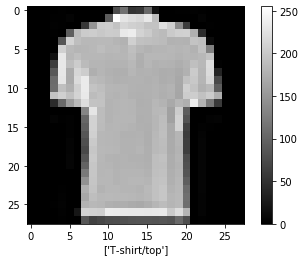

In [20]:
GraficaPrediccion(test_images_sub[190])

In [21]:
dict_labels[test_labels_sub[190]]

'T-shirt/top'

In [22]:
pruebas_random = np.random.choice(len(test_images_sub), 5)
imagenes_random = [test_images_sub[x] for x in pruebas_random]

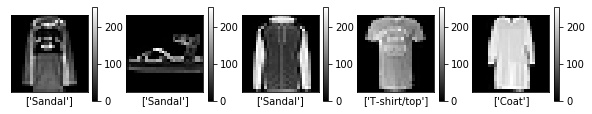

In [23]:
plt.figure(figsize=(10,10))

for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    GraficaPrediccion(imagenes_random[i])
plt.show()